<a href="https://colab.research.google.com/github/Nickimani/Airbnb_Project/blob/master/Airbnb_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airbnb Project

# 1. Business Understanding 

# 2. Data Understanding

# 3. Loading Data

## 3.1 Importing Libraries

In [79]:
# connecting to drive
from google.colab import drive
drive.mount('/content/drive', timeout_ms=900000) # timeout = 15 min

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
# installing necessary libraries
# Reverse geoencoder
!pip install reverse_geocoder 
# pandas profiling
!pip install pandas_profiling

!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
# importing libraries

import string
import time
import re
import pickle

import pandas as pd
import pandas_profiling as pp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import reverse_geocoder as rg

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

In [168]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## 3.2 Loading The DataFrames

In [82]:
# loading the DataFrames
listings_df = pd.read_csv('/content/drive/Shareddrives/CapStone/Data/listings.csv')
reviews_df = pd.read_csv('/content/drive/Shareddrives/CapStone/Data/reviews.csv')
metadata_df = pd.read_csv('/content/drive/Shareddrives/CapStone/Data/data_dictionary.csv')

In [83]:
# a function returning the datastructure of a the input dataframe
def data_structure(dataframe, data_name):
    """ 
    Returns datashape and data info. 
    """
    print(f'{data_name} dataframe shape:', dataframe.shape)
    print('-'*120)
    print(dataframe.info())

# a function returning a dataframe of the completeness of the features in the input dataframe
def percentage_completeness(dataframe):
    """
    Returns a dataframe showcasing the percentage completeness of the columns in a dataframe    
    """
    # length of dataframe
    tot_entries = len(dataframe) 
    # name of columns list
    columns = list(dataframe.columns) 
    perc_completeness = [] 

    for column in columns:
        # taking number of missing records
        missing = dataframe[column].isna().sum() 
        # calculating percentage of completeness in column
        perc_null_counts = (1 - (missing / tot_entries)) * 100 
        perc_completeness.append(round(perc_null_counts, 2)) 
    # creating dataframe of column and completeness
    output = pd.DataFrame(list(zip(columns, perc_completeness)), 
                          columns=['Feature', '%_completeness']) 
    # sorting the values
    output = output.sort_values(by='%_completeness', ascending=True) 
    output.reset_index(inplace=True, drop=True)

    return output

# a function that pulls valuecounts from a column
def value_count(dataframe, column):
    """
    Returns the value counts for unique value in the column specified
    """
    # getting the value counts
    val_count = dataframe[column].value_counts() 
    # converting list output to dataframe
    result = val_count.to_frame(name='Count(s)') 

    return result

# a funtion for removing the % sign from the strings    
def strip_signs(dataframe, column):
    """
    Takes in a dataframe and the column to be cleaned. 
    The column should have a prefix of suffix that if removed,would make the column convertible to a numeric datatype
    Returns a replacement of the input column cleaned and converted to float dtype.
    """
    # making sure its a series
    feature = pd.Series(dataframe[column]) 
    # striping % sign from string
    feature = feature.str.strip(to_strip='%') 
    # converting datatype
    final_feature = feature.astype('float') 

    return final_feature


# a function for plotting a boxplot for a series
def box_plot(series):
    """
    Returns a boxplot of the column specified    
    """
    fig, ax = plt.subplots(figsize=(20,10))
    # creating the boxplot
    ax = sns.boxplot(x=series, linewidth=1, palette='Set2') 
    # Give the plot a main title
    ax.set_title(f'{series.name}, Airbnb Cape town', fontsize=30,pad=30) 
    # Set text for the x axis,
    ax.set_xlabel(series.name, fontsize=20, labelpad=15)
    sns.despine(offset=5, left=True);

# Build a function for regex stripping maybe linked to strip signs

### Data Structure

In [84]:
# data_structure(listings_df, 'listing_df') # listings df structure

The listings dataFrame has 18903 rows with 74 columns. 41 of the columns are of numeric type and The remaining 33 are of object type.

In [85]:
# selecting important columns as per the business problem
relevant_cols = ['id', 'listing_url', 'host_url', 'last_scraped', 'name', 'description', 
                 'neighborhood_overview', 'host_since', 'neighbourhood_cleansed', 
                 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
                 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
                 'amenities', 'price', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
                 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                 'review_scores_location', 'instant_bookable', 'calculated_host_listings_count'
                 ]
# subsetting a dataframe of the relevant columns
listings_df = listings_df[relevant_cols]

In [86]:
# new_listings df structure
data_structure(listings_df, 'listing_df') 

listing_df dataframe shape: (18903, 32)
------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18903 entries, 0 to 18902
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              18903 non-null  int64  
 1   listing_url                     18903 non-null  object 
 2   host_url                        18903 non-null  object 
 3   last_scraped                    18903 non-null  object 
 4   name                            18903 non-null  object 
 5   description                     18560 non-null  object 
 6   neighborhood_overview           11610 non-null  object 
 7   host_since                      18902 non-null  object 
 8   neighbourhood_cleansed          18903 non-null  object 
 9   host_response_time              14710 non-null  object

In [87]:
# viewing listings df
listings_df.head(3) 

,id,listing_url,host_url,last_scraped,name,description,neighborhood_overview,host_since,neighbourhood_cleansed,host_response_time,...,price,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,instant_bookable,calculated_host_listings_count
0,30332317,https://www.airbnb.com/rooms/30332317,https://www.airbnb.com/users/show/98554302,2022-06-22,Riverside cottage,Riverside cottage is a comfortable unit with v...,NaN,2016-10-07,Ward 15,within an hour,...,"$1,350.00",2,5.00,5.0,5.0,5.0,5.0,5.00,t,7
1,9126484,https://www.airbnb.com/rooms/9126484,https://www.airbnb.com/users/show/3410651,2022-06-22,Jubilee Square Apartment,Comfortably furnished 1st floor 2 bedroom apar...,The apartment is situated on the main street d...,2012-08-29,Ward 61,within a few hours,...,"$1,750.00",15,4.87,5.0,5.0,5.0,5.0,4.93,f,1
2,44482125,https://www.airbnb.com/rooms/44482125,https://www.airbnb.com/users/show/98554302,2022-06-22,Willow Cottage,Willow cottage overlooks our rose gardens and ...,NaN,2016-10-07,Ward 15,within an hour,...,"$1,350.00",0,NaN,NaN,NaN,NaN,NaN,NaN,t,7


In [88]:
# reviews_df structure
data_structure(reviews_df, 'reviews_df') 

reviews_df dataframe shape: (363065, 6)
------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363065 entries, 0 to 363064
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     363065 non-null  int64 
 1   id             363065 non-null  int64 
 2   date           363065 non-null  object
 3   reviewer_id    363065 non-null  int64 
 4   reviewer_name  363065 non-null  object
 5   comments       363018 non-null  object
dtypes: int64(3), object(3)
memory usage: 16.6+ MB
None


Reviews dataframe has only 1 column with nan values.
The nature of the comments column makes it difficult to fill the nan values.

In [89]:
# dropping nan values in reviews_df
reviews_df.dropna(inplace=True)

# viewing reviews df
reviews_df.head(3) 

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,30332317,597314314,2020-01-25,7812767,Alan,Lovely rustic accommodation in a picturesque r...
1,30332317,532436007654450454,2022-01-04,367340518,Courtney,The hosts are friendly and takes good care of ...
2,9126484,63063726,2016-02-20,50272994,Carla,6 St Georges Building was lovely in every way....


# 4. Data cleaning

## 4.1 Completeness

In [90]:
# checking percentage null value counts in listings 
listings_completeness = percentage_completeness(listings_df) 
# filtering out columns with complete records
listings_completeness = listings_completeness[listings_completeness['%_completeness'] < 100] 
listings_completeness

,Feature,%_completeness
0,neighborhood_overview,61.42
1,review_scores_location,71.97
2,review_scores_checkin,71.97
3,review_scores_communication,71.98
4,review_scores_accuracy,71.98
5,review_scores_cleanliness,71.99
6,review_scores_rating,72.79
7,host_response_time,77.82
8,host_response_rate,77.82
9,host_acceptance_rate,87.51


In [91]:
# checking number of columns with missing values
print('The number of columns with missing values are:', len(listings_completeness))

The number of columns with missing values are: 16


### neighborhood overview

In [92]:
listings_df['neighborhood_overview'] = listings_df['neighborhood_overview'].fillna('')

### description column

In [93]:
listings_df['description'] = listings_df['description'].fillna('')

### 'review_score' features

Dealing with columns that have 'review_score' in their labels. 

There is ~30% missing values in 'review_score_' columns.

In [94]:
# Creating a list of the review_score columns
review_list = [column for column in listings_df.columns if 'review_score' in column.strip()]
# subsetting a dataframe of review list
review_cols_df = listings_df[review_list].copy() 
# checking the datatype for these columns
listings_df[review_list].dtypes

review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
dtype: object

All review_score_ columns are of numeric type.

In [95]:
# checking the column descriptions
review_cols_df.describe().T 

,count,mean,std,min,25%,50%,75%,max
review_scores_rating,13760.0,4.666231,0.684017,0.0,4.64,4.86,5.0,5.0
review_scores_accuracy,13607.0,4.757262,0.490736,0.0,4.73,4.91,5.0,5.0
review_scores_cleanliness,13608.0,4.730264,0.492878,0.0,4.67,4.89,5.0,5.0
review_scores_checkin,13604.0,4.808905,0.462444,0.0,4.81,4.97,5.0,5.0
review_scores_communication,13607.0,4.802807,0.479074,0.0,4.81,4.97,5.0,5.0
review_scores_location,13604.0,4.803673,0.414366,0.0,4.78,4.93,5.0,5.0


The missing values will be filled with the median of the respective column.

In [96]:
# imputing missing values with median
listings_df[review_list] = listings_df[review_list].fillna(listings_df[review_list].median())

In [97]:
# rounding off ratings values 
listings_df[review_list] = listings_df[review_list].round(0)

In [98]:
# checking value counts
for feature in review_list:
    print(value_count(listings_df, feature))
    # limiting long output

     Count(s)
5.0     16284
4.0      2140
3.0       190
0.0       138
1.0       102
2.0        49
     Count(s)
5.0     17003
4.0      1585
3.0       165
1.0       105
2.0        44
0.0         1
     Count(s)
5.0     16621
4.0      1932
3.0       205
1.0        88
2.0        56
0.0         1
     Count(s)
5.0     17400
4.0      1242
3.0       128
1.0        99
2.0        33
0.0         1
     Count(s)
5.0     17337
4.0      1282
3.0       132
1.0       101
2.0        49
0.0         2
     Count(s)
5.0     17424
4.0      1280
3.0       100
1.0        69
2.0        29
0.0         1


The number of rating scores that equal to 0 after rouding off are negligible compared to the size of the dataset and other class couts. A zero rating doesn't make much sense, changing them to 1 is more sensible.

In [99]:
for feature in review_list:
    # replacing 0 values with 1
    listings_df[feature] = listings_df[feature].replace(to_replace=0, value=1) 

### bedrooms & beds features
~6% of data is missing from bedrooms and ~2% is missing from beds columns.

In [100]:
# bedrooms unique values
print(listings_df['bedrooms'].unique()[:23])
print()
# beds unique values
print(listings_df['beds'].unique()[:10])

[ 1.  2.  5.  3. nan  6.  4. 10.  7.  8.  9. 12. 16. 19. 41. 40. 11. 14.
 13. 18. 17. 15. 20.]

[ 1.  3.  2.  4.  5.  6.  8. nan  7. 49.]


There seems to be outliers in these columns. 

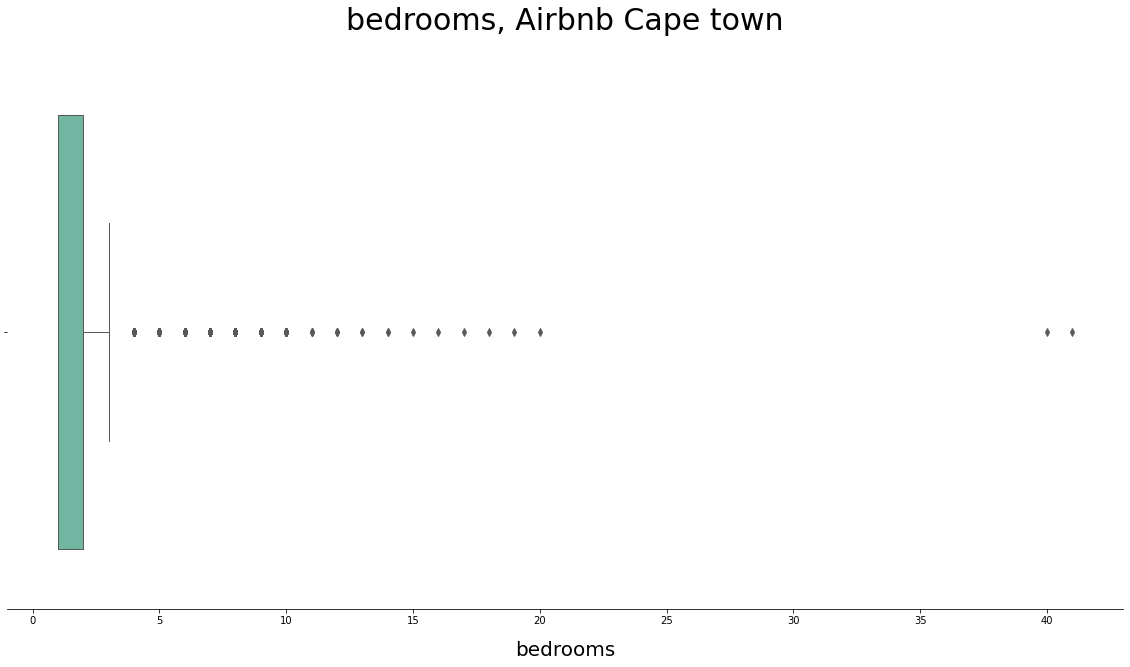

In [101]:
# checking if there are outliers in the bedrooms column
box_plot(listings_df['bedrooms'])

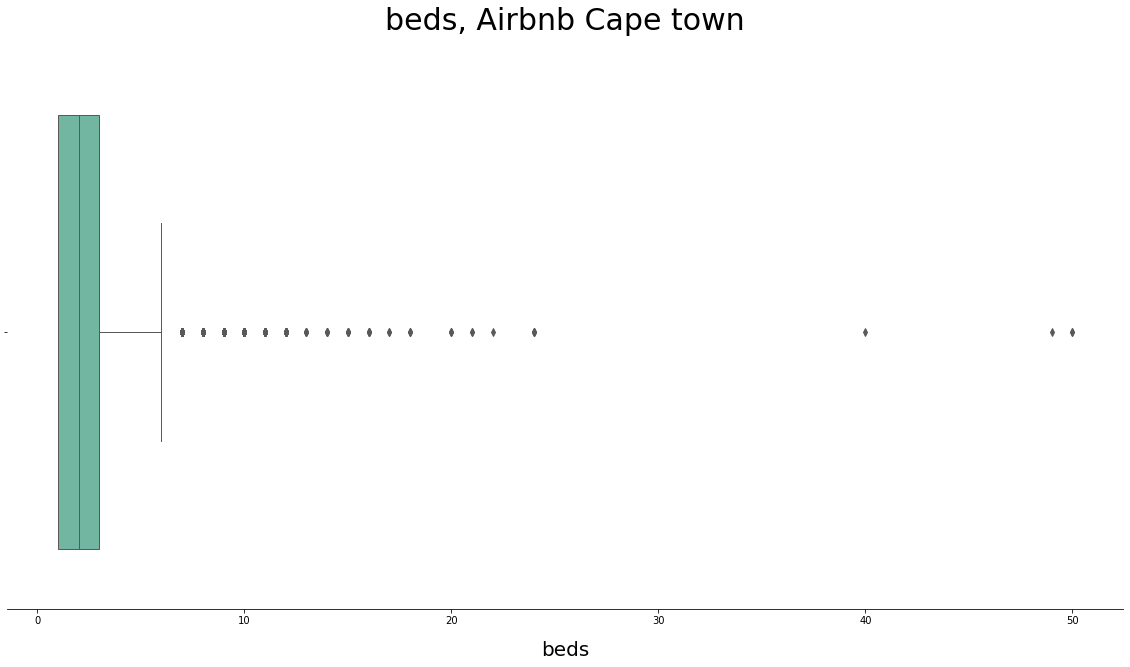

In [102]:
# checking if there are outliers in the bed column
box_plot(listings_df['beds']) 

In [103]:
# subsetting extreme outliers in bedrooms and beds columns
listings_df[(listings_df['bedrooms'] >= 24) | (listings_df['beds'] >= 24)][['bedrooms', 'beds', 'price', 'bathrooms_text']]

,bedrooms,beds,price,bathrooms_text
148,10.0,49.0,$840.00,32 baths
1742,12.0,24.0,"$3,361.00",2 baths
7064,12.0,24.0,"$9,800.00",6 baths
8401,41.0,50.0,"$1,689.00",1 bath
8966,40.0,50.0,$807.00,42 baths
12250,1.0,24.0,$350.00,1 shared bath
12517,14.0,24.0,$400.00,2 shared baths
12518,13.0,40.0,$686.00,9 baths


In [104]:
# shape before dropping outliers
print('Shape Before:', np.shape(listings_df))
# dropping outliers
listings_df = listings_df[listings_df['beds'] < 24].copy()
listings_df = listings_df[listings_df['bedrooms'] < 24].copy()
# shape after
print('Shape After:', np.shape(listings_df))
# values dropped
print('Records dropped:', 1428)

Shape Before: (18903, 32)
Shape After: (17475, 32)
Records dropped: 1428


median for bedrooms is 1 and for beds is 2.

In [105]:
# fill missing values with the median
listings_df['bedrooms'].fillna(value=listings_df['bedrooms'].median(), inplace=True)
# fill missing values
listings_df['beds'].fillna(value=listings_df['beds'].median(), inplace=True)

### bathrooms_text feature
~2% of data is missing in bathrooms_text column.

In [106]:
# checking bathrooms unique values
listings_df['bathrooms_text'].unique()[:10] 

array(['1 bath', '2 baths', '1.5 baths', '5 baths', '3 baths',
       '3.5 baths', '1 private bath', '6.5 baths', '2.5 baths',
       '4.5 baths'], dtype=object)

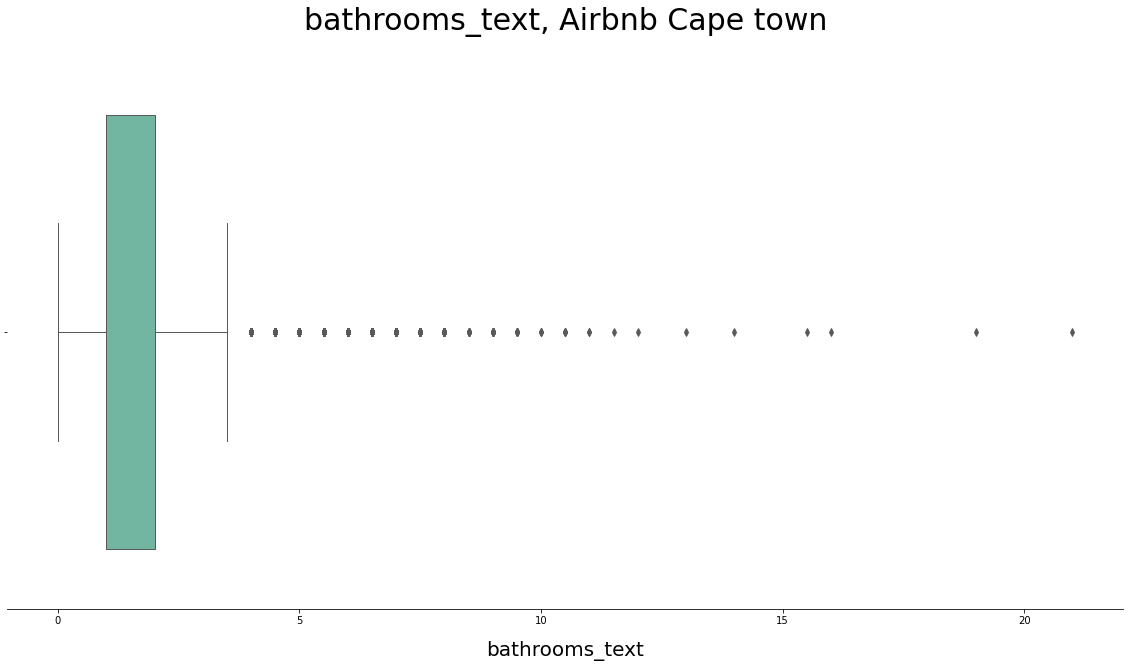

In [107]:
# strip the records to remain with the numerical value strings
listings_df['bathrooms_text'] = listings_df['bathrooms_text'].str.extract('(\d+\.?\d*)')
# changing column to float
listings_df['bathrooms_text'] = listings_df['bathrooms_text'].astype('float')
# checking if there are outliers in bathrooms_text
box_plot(listings_df['bathrooms_text']) 

bathrooms median is 1.

In [108]:
# fill missing values with median
listings_df['bathrooms_text'].fillna(value=listings_df['bathrooms_text'].median(), inplace=True) 
# changing column name 
listings_df.rename(columns={'bathrooms_text': 'bathrooms'}, inplace=True)

### 'host' features

Dealing with host_response_time, host_response_rate & host_acceptance_rate columns.

host_response_time and host_response_rate have ~23% of missing data, and host_acceptance_rate has ~13% of missing data.

In [109]:
# making a list of the columns being tackled
host_reactions = ['host_response_time', 'host_response_rate', 'host_acceptance_rate']
# checking unique counts
print('host_response_time unique counts are:', listings_df[host_reactions[0]].nunique())
print()
print(listings_df['host_response_time'].unique())
print()
print('host_response_rate unique counts are:', listings_df[host_reactions[1]].nunique())
print()
print(listings_df[host_reactions[1]].unique()[:10])
print()
print('host_acceptance_rate unique counts are:', listings_df[host_reactions[2]].nunique())
print()
print(listings_df[host_reactions[2]].unique()[:10])

host_response_time unique counts are: 4

['within an hour' 'within a few hours' nan 'within a day'
 'a few days or more']

host_response_rate unique counts are: 42

['100%' nan '50%' '80%' '87%' '67%' '75%' '33%' '90%' '70%']

host_acceptance_rate unique counts are: 87

['100%' '50%' '67%' '71%' nan '94%' '93%' '11%' '83%' '99%']


host_response_time is a categorical column, its missing values will be imputed with 'unknown' as a category. The other 2 columns should be numerical but have been recorded as strings. Some manipulations need to be done to them.

In [110]:
# filling nan values with unknown
listings_df['host_response_time'] = listings_df['host_response_time'].fillna('unknown') 
# stripping % signs from the columns
listings_df['host_response_rate'] = strip_signs(listings_df, 'host_response_rate')
listings_df['host_acceptance_rate'] = strip_signs(listings_df, 'host_acceptance_rate') 

host_response_rate median is 100% while host_acceptance median is 95%. Is that the general trend?

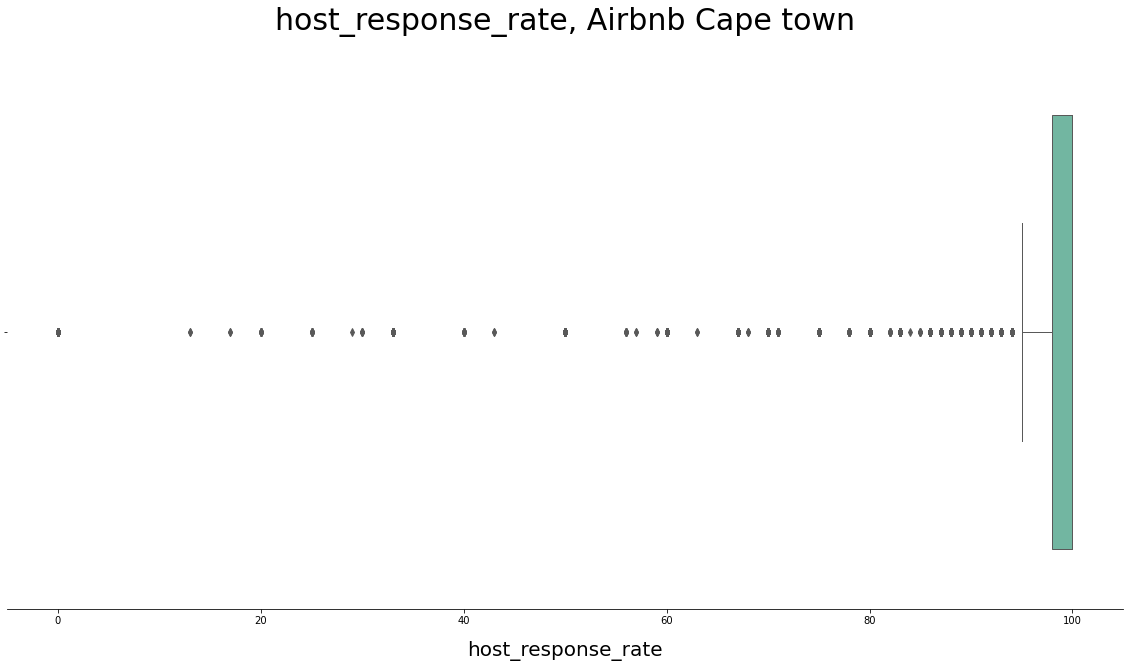

In [111]:
# boxplot of host_response_rate
box_plot(listings_df['host_response_rate'])

In [112]:
# filling missing values with median
listings_df['host_response_rate'].fillna(value=listings_df['host_response_rate'].median(), inplace=True) 

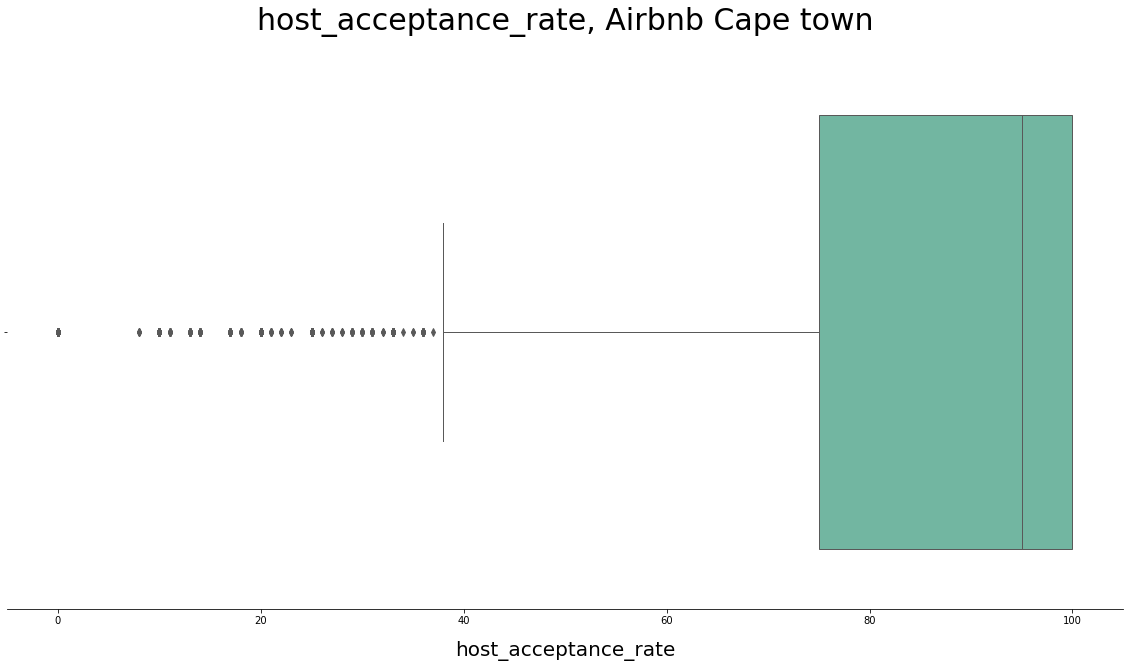

In [113]:
# boxplot of host_acceptance rate
box_plot(listings_df['host_acceptance_rate']) 

In [114]:
# filling missing values with median
listings_df['host_acceptance_rate'].fillna(value=listings_df['host_acceptance_rate'].median(), inplace=True)

acceptance rate and response rate need to be transformed to categorical variables. To do that rounding off of the values required.

In [115]:
# rounding off the values
listings_df['host_acceptance_rate'] = listings_df['host_acceptance_rate'].apply(lambda x: round(x, -1))
listings_df['host_response_rate'] = listings_df['host_response_rate'].apply(lambda x: round(x, -1))

Dealing with the remaining 'host' features, which are: host_name, host_since, host_identity_verified, host_is_superhost, host_has_profile_pic, host_picture_url, host_listings_count & host_total_listings_count columns.

In [116]:
# list of 'host' columns that have been dealt with already
already_dealt = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_location']
# making a list of columns containing 'host' in their names but that haven't been dealt with
rem_host_cols = [column for column in listings_df.columns if 'host' in column.strip() and column not in already_dealt]
# filtering out 'host columns' that are complete
host_traits = [column for column in rem_host_cols if column in list(listings_completeness['Feature'])]
host_traits

['host_since', 'host_is_superhost']

both of them have ~0.01% of missing values

In [117]:
# sum of nan values in host_since
print(listings_df['host_since'].isna().sum())
# Dropping null row 
listings_df.dropna(subset= ["host_since"], inplace= True) 

1


In [118]:
# viewing the host columns
listings_df[host_traits].head(3) 

,host_since,host_is_superhost
0,2016-10-07,f
1,2012-08-29,f
2,2016-10-07,f


The host_since column contains dates of when a host started being a host. The values in this column will be sliced, and only the year will be left. The column will also be transformed into a integer data type.

In [119]:
# slicing the year off the records
listings_df['host_since'] = listings_df['host_since'].apply(lambda x: x[:4]) 
# changing column to int
listings_df['host_since'] = listings_df['host_since'].astype(int) 

host is superhost needs to be transformed into a better representation for a binary category.

In [120]:
# repacing values to make column a bool dtype
listings_df['host_is_superhost'] = listings_df['host_is_superhost'].replace({'t': 1, 'f': 0})

## 4.2 uniqueness

In [121]:
# checking for duplicates
listings_df.drop(columns='amenities').duplicated().sum()

0

## 4.3 Cleaning remaining features

### instant_bookable feature

In [122]:
# checking value_counts
listings_df['instant_bookable'].value_counts()

f    9805
t    7669
Name: instant_bookable, dtype: int64

In [123]:
# repacing values to make column a bool dtype
listings_df['instant_bookable'] = listings_df['instant_bookable'].replace({'t': 1, 'f': 0})

### coordinate features

Dealing with latitude & longitude 

In [124]:
test = listings_df[['latitude', 'longitude']].copy()
# reseting index of test
test.reset_index(inplace= True)

In [125]:
len(test)

17474

In [126]:
#  loop to obtain name of cities
# cities= []
# for i in range(len(test)):
#   coordinates = (test['latitude'][i], test['longitude'][i])
#   geo_coord = rg.search(coordinates)
#   city = geo_coord[0]['name']
#   cities.append(city)
#   time.sleep(.001)


In [127]:
# with open('/content/drive/Shareddrives/CapStone/Data/cities.pkl', 'wb') as f:
#   pickle.dump(cities, f)

In [128]:
with open('/content/drive/Shareddrives/CapStone/Data/cities.pkl', 'rb') as f:
  cities = pickle.load(f)

In [129]:
# merging to the listings dataframe, dropping longitudes and latitude
listings_df.reset_index(inplace= True)
listings_df['cities'] = cities
listings_df.drop(columns= ['latitude', 'longitude'], inplace= True)

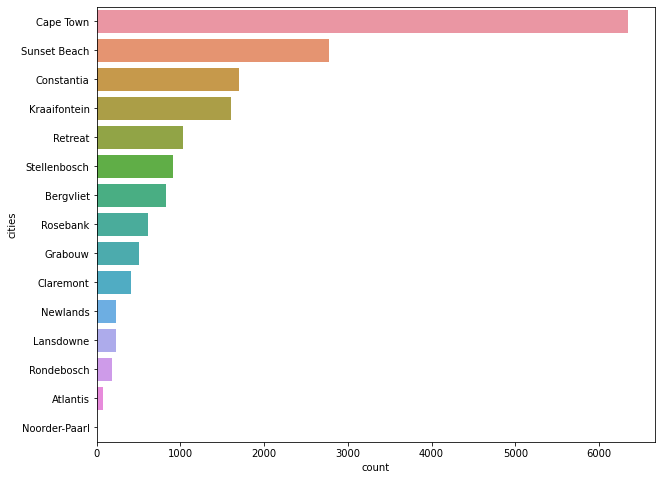

In [130]:
fig = plt.figure(figsize= (10, 8))
sns.countplot(y= 'cities', data= listings_df, order= listings_df['cities'].value_counts().index);

Cape Town has the most airbnb homes. Noorder-Paarl has the least airbnb homes. The variation in the number of airbnbs could be attributed to different factors in this dataset, for example, Cape Town is the capital of this province and hence a more attractive investment prospect especially in the hospitality field.

### amenities feature & amenities_count feature engineering

In [131]:
# viewing amenities column
listings_df['amenities'].head() 

0    ["Hot water", "Cooking basics", "Iron", "Free ...
1    ["Hot water", "Cooking basics", "Iron", "Dryin...
2    ["TV", "Long term stays allowed", "Cooking bas...
3    ["TV", "Gym", "Long term stays allowed", "Heat...
4    ["TV", "Long term stays allowed", "Heating", "...
Name: amenities, dtype: object

In [132]:
# Splitting amenities column and get amenities count words
# then creating a new column "amenities_count"

# listings_df['amenities_count'] = listings_df['amenities'].str.split(',').str.len()
# # tramsform amenities records from list to string type
# # listings_df.amenities = listings_df['amenities'].str.replace("[{}]", "").str.replace('"', "").str.replace('[',"").str.replace(']',"")

# creating a list of lower and uppercase letters 
letters = string.ascii_letters
# splitting each record to extract the amenities
amenities_split = listings_df['amenities'].apply(lambda x: x.split('"'))
new_amenities = []
# making a list of lists 
for split in amenities_split:
    res = [x for x in split if x[0] in letters]
    new_amenities.append(res)

# replacing amenities with the list of lists
listings_df['amenities'] = new_amenities
# engineering a new column that is the count of amenities per record
listings_df['amenities_count'] = listings_df['amenities'].apply(lambda x: len(x))
# checking unique counts
listings_df['amenities_count'].nunique()

81

In [133]:
listings_df['amenities_count'].value_counts().head(40)

10    545
9     464
17    442
5     438
16    436
18    431
15    430
27    423
13    422
14    418
29    415
24    411
31    409
19    409
20    407
25    404
21    397
12    395
30    393
23    389
11    386
22    386
34    378
28    376
26    367
33    366
32    360
35    356
39    343
36    308
37    300
38    292
40    285
41    280
8     275
43    268
42    232
44    229
7     226
45    225
Name: amenities_count, dtype: int64

In [134]:
listings_df[listings_df['amenities_count'] > 70]['amenities'][403]

['Board games',
 'Hot water',
 'Cleaning products',
 'Cooking basics',
 'Indoor fireplace',
 'Iron',
 'Drying rack for clothing',
 'TV with standard cable',
 'Coffee maker',
 'BBQ grill',
 'Dining table',
 'Washer',
 'Ethernet connection',
 'Pocket wifi',
 'Portable fans',
 'Private hot tub',
 'Free residential garage on premises \\u2013 4 spaces',
 'Private pool',
 'Bed linens',
 'Free street parking',
 'Freezer',
 'Dryer',
 'High chair',
 'Shampoo',
 'Clothing storage: wardrobe',
 'Crib',
 'Bathtub',
 'Outdoor furniture',
 'Private entrance',
 'Keypad',
 'Cleaning before checkout',
 'Wifi',
 'Safe',
 'Outdoor dining area',
 'Heating',
 'Conditioner',
 'Children\\u2019s books and toys for ages 0-2 years old',
 'Baking sheet',
 'Private patio or balcony',
 'Changing table',
 'Stove',
 'Elevator',
 'Extra pillows and blankets',
 'Hot water kettle',
 'Wine glasses',
 'Children\\u2019s dinnerware',
 'First aid kit',
 'Microwave',
 'Refrigerator',
 'Hair dryer',
 'Laundromat nearby',
 'Bar

### last_scraped feature & hosting_duration feature engineering

In [135]:
# viewing 'scrape' columns
listings_df['last_scraped'].head(2) 

0    2022-06-22
1    2022-06-22
Name: last_scraped, dtype: object

In [136]:
# slicing the year from last scraped
listings_df['last_scraped'] = listings_df['last_scraped'].apply(lambda x: x[:4]) 
# changing column data type
listings_df['last_scraped'] = listings_df['last_scraped'].astype(int) 
# creating a column to show age of the host
listings_df['hosting_duration'] = listings_df['last_scraped'] - listings_df['host_since']
# dropping last_scrapped and host_since columns
listings_df.drop(columns= ['last_scraped', 'host_since'], inplace= True) 

### Price column

In [137]:
listings_df.price[:2]

0    $1,350.00
1    $1,750.00
Name: price, dtype: object

In [138]:
# changing price to numeric
listings_df.price = listings_df.price.replace('[\$,]', '', regex=True).astype(float)

Our data cleaning is finished. Now we do bivariate analysis

# 5. EDA

In [139]:
# categorical variables 
categorical_cols = ['host_response_time', 'host_response_rate','host_acceptance_rate', 'host_is_superhost', 'room_type',
                    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'hosting_duration', 'review_scores_rating', 
                    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                     'review_scores_location', 'instant_bookable', 'calculated_host_listings_count', 'amenities_count']
                        

## 5.1 Binning some categorical columns

In [140]:
# function to bin host response rate and acceptance rate
def bin_column(dataframe, column, new_col):
 
  bins = [0, 50, 70, 89, 100]
  labels = ['0-50', '51-70', '71-89', 'above 90']
  dataframe[new_col] = pd.cut(dataframe[column], bins=bins, labels=labels)

  return dataframe.head(1)


### 5.1.1 host response rate and host acceptance rate

In [141]:
#host response rate
bin_column(listings_df,'host_response_rate','response_rate')

# host_acceptance rate
bin_column(listings_df,'host_acceptance_rate','acceptance_rate')

,index,id,listing_url,host_url,name,description,neighborhood_overview,neighbourhood_cleansed,host_response_time,host_response_rate,...,review_scores_checkin,review_scores_communication,review_scores_location,instant_bookable,calculated_host_listings_count,cities,amenities_count,hosting_duration,response_rate,acceptance_rate
0,0,30332317,https://www.airbnb.com/rooms/30332317,https://www.airbnb.com/users/show/98554302,Riverside cottage,Riverside cottage is a comfortable unit with v...,,Ward 15,within an hour,100.0,...,5.0,5.0,5.0,1,7,Stellenbosch,23,6,above 90,above 90


### 5.1.2 accommodates,beds,bedrooms,bathrooms columns

In [142]:
listings_df[['accommodates','beds','bedrooms','bathrooms']].corr()

,accommodates,beds,bedrooms,bathrooms
accommodates,1.000000,0.853642,0.888412,0.798609
beds,0.853642,1.000000,0.828616,0.719420
bedrooms,0.888412,0.828616,1.000000,0.848388
bathrooms,0.798609,0.719420,0.848388,1.000000


* These features seem to be strongly correlated which means they give us same information and thus we decided to use one of them(accommodates) for our analysis

In [143]:
# binning the accommodates column
bins = [0, 4, 8, 12, 16]
labels = ['1-4 people', '5-8 people', '9-12 people', 'above 12 people']
listings_df['accommodate'] = pd.cut(listings_df['accommodates'], bins=bins, labels=labels)

### 5.1.3 Number of amenities

In [144]:
bins = [0, 10, 20, 30, 100]
labels = ['0-10', '11-20', '21-30', 'above 30']
listings_df['amenities_binned'] = pd.cut(listings_df['amenities_count'], bins=bins, labels=labels)

### 5.1.4 Which are the most common amenities in the high rated airbnbs?

In [145]:
# listings with overall rating of 5
high_listings = listings_df[listings_df.review_scores_rating == 5]


In [146]:
# function to turn a 2D list into 1D
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [147]:
#get the value_counts
common_amenities = to_1D(high_listings['amenities']).value_counts()
# top 30 amenities
top_30 = common_amenities[:30]

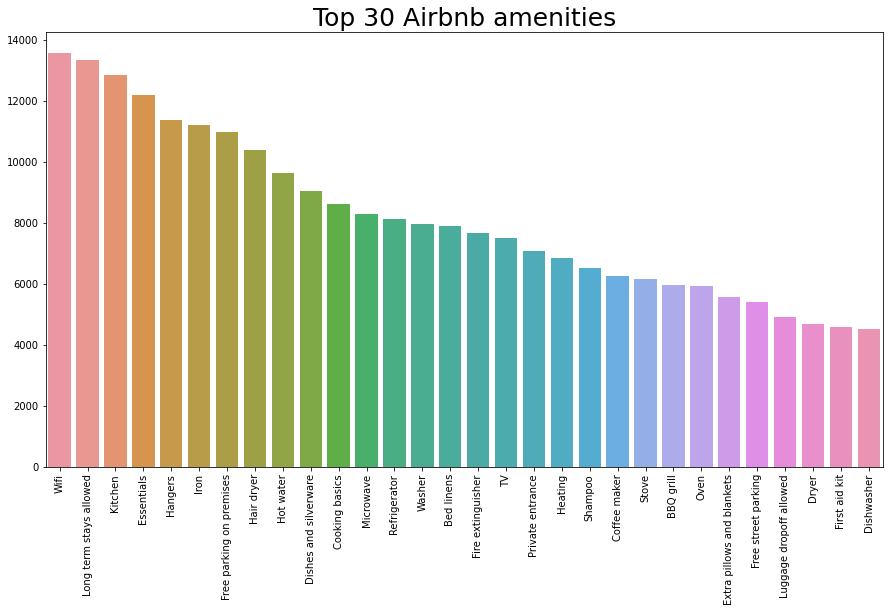

In [148]:
fig, ax = plt.subplots(figsize = (15,8))
sns.barplot(x = top_30.index, y = top_30)
ax.set_title('Top 30 Airbnb amenities', fontsize=25)
plt.xticks(rotation = 90);

## 5.2 Question: Does it make a difference being a superhost?

Being a superhost takes a lot of work. To be a superhost you should:
  * Have an average rating of 4.8 and above
  * Have a response rate and acceptance rate of at least 90%
  * Have a <1% cancellation rate per year
  * Response time within a day<br>


### 5.2.1 Lets check how being a superhost affects the average score rating
During this analysis, we decided to use the data that had number of reviews greater than 4 to minimize biased rating scores

In [149]:
new = listings_df[listings_df['number_of_reviews']>=5]

There is a class imbance in the column that defines if someone is a superhost or not so an equal sample size was taken for both superhost and non superhost for better analysis and comparison

In [150]:
new['host_is_superhost'].value_counts()

0    5549
1    2820
Name: host_is_superhost, dtype: int64

In [151]:
not_superhost = new[new.host_is_superhost == 0].sample(2820)
super_host = new[new.host_is_superhost == 1]
new_df1 = pd.concat([not_superhost, super_host])

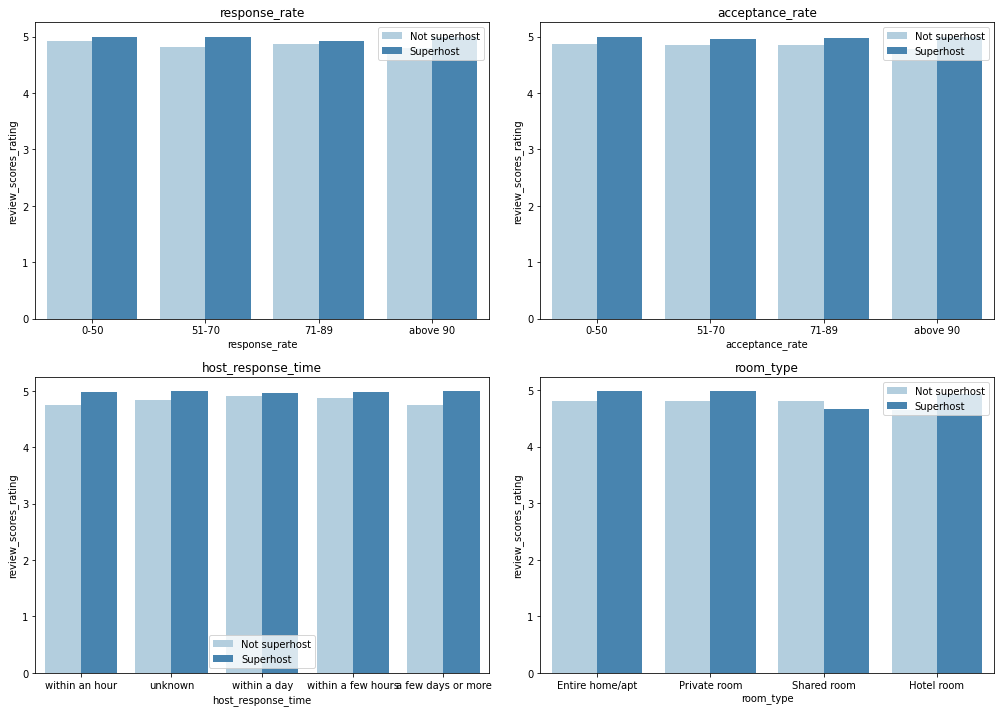

In [152]:
cols = ['response_rate', 'acceptance_rate', 'host_response_time', 'room_type']

a = 2  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,10))

for i in cols:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    plt.xlabel(i)
    sns.barplot(x = i,y='review_scores_rating', data=new_df1,hue='host_is_superhost', ci=None, palette='Blues')
    plt.legend(labels=['Not superhost','Superhost'], loc='best')
    c = c + 1

plt.tight_layout()
plt.show()

* We can see that for the same response rate,acceptance rate, response_time and room type, the superhosts tend to get a higher review score rating than a standard host. Higher ratings increase customer flow which leads to more income

### 5.2.2 Now lets check how is the distribution of the response rate, acceptance_rate, response_time and hosting duration 

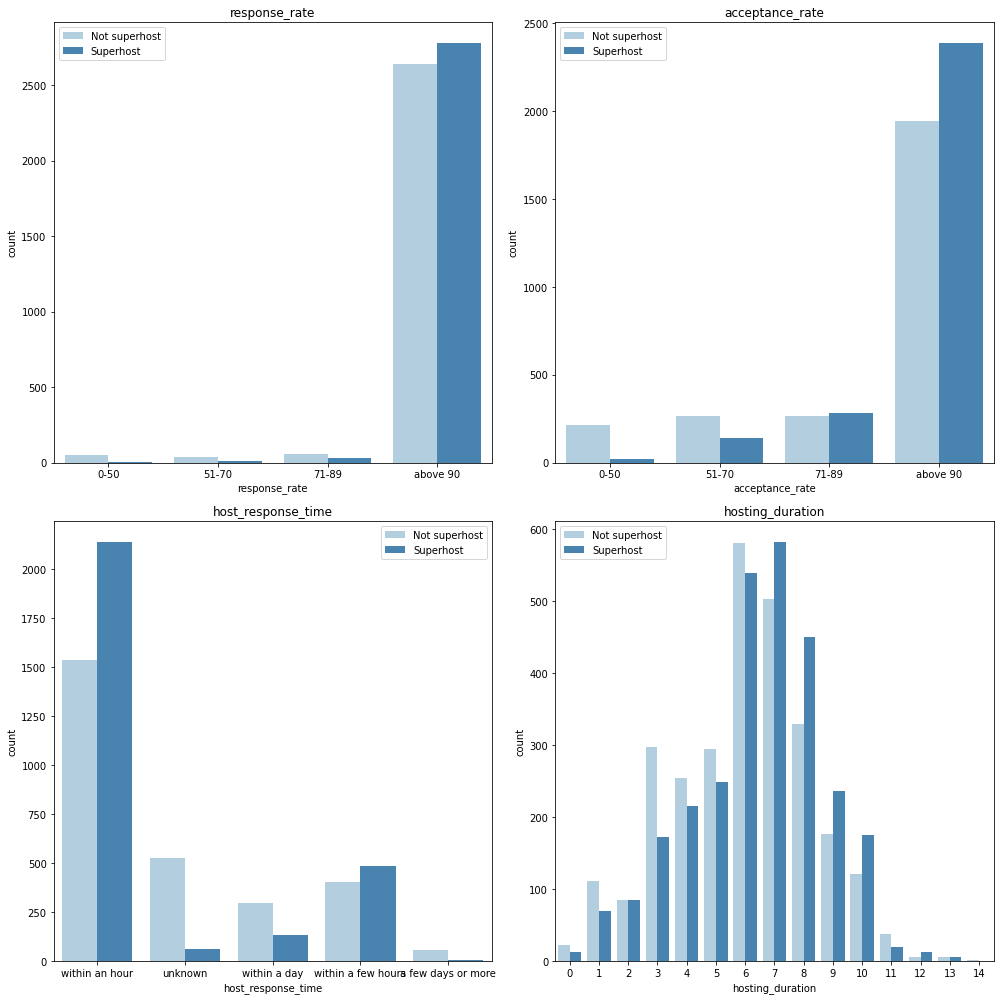

In [153]:

cols = ['response_rate', 'acceptance_rate', 'host_response_time','hosting_duration']

a = 2  
b = 2  
c = 1  

fig = plt.figure(figsize=(14,14))

for i in cols:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    plt.xlabel(i)
    sns.countplot(x = i, data=new_df1,hue='host_is_superhost', palette='Blues')
    plt.legend(labels=['Not superhost','Superhost'], loc='best')
    c = c + 1

plt.tight_layout()
plt.show()

* Despite some few outliers, the high numbers in response rate, acceptance rate and response time go hand in hand with the expected superhost rates of above 90% and response time of within a day.
* High numbers of standard hosts can also be seen with the same high rates. However, there are more of these hosts in the lower categories
* Although there are hosts who become superhosts in the early years, this starts to peak at 6 years. It seems it takes time for most people to become superhosts

### 5.2.3 How do the different scores(accuracy, location, checkin, cleanliness) affect the overall rating for superhosts vs standard hosts?

In [154]:
# correlation between average score rating and the constituent scores
ratings_corr = new_df1[['review_scores_rating','review_scores_location', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_accuracy']].corr()
ratings_corr.loc[:,'review_scores_rating']

review_scores_rating         1.000000
review_scores_location       0.415929
review_scores_cleanliness    0.577816
review_scores_checkin        0.481252
review_scores_accuracy       0.658939
Name: review_scores_rating, dtype: float64

* Accuracy and cleanliness seem the most correlated with the average overall rating. Location is the least

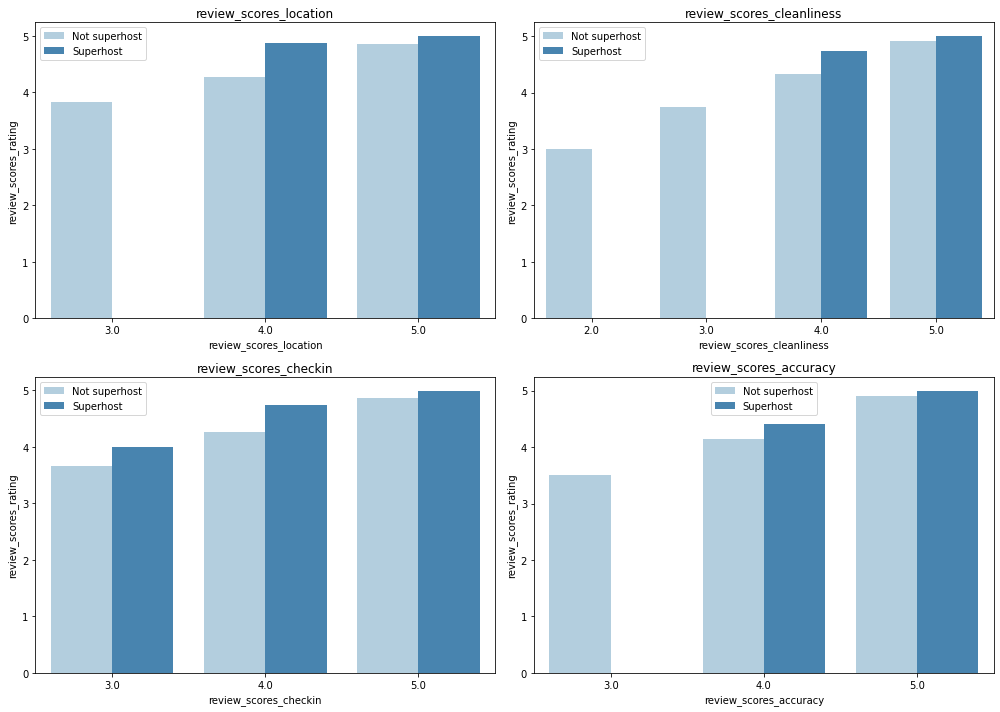

In [155]:

cols = ['review_scores_location', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_accuracy']

a = 2  
b = 2
c = 1  

fig = plt.figure(figsize=(14,10))

for i in cols:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    plt.xlabel(i)
    sns.barplot(x = i,y='review_scores_rating', data=new_df1,hue='host_is_superhost', ci=None, palette='Blues')
    plt.legend(labels=['Not superhost','Superhost'], loc='best')
    c = c + 1

plt.tight_layout()
plt.show()

* Superhosts take the day in overall score ratings against standard hosts given same score of constituent ratings

### 5.2.4 Let us now see how is the pricing between the standard hosts and the superhosts

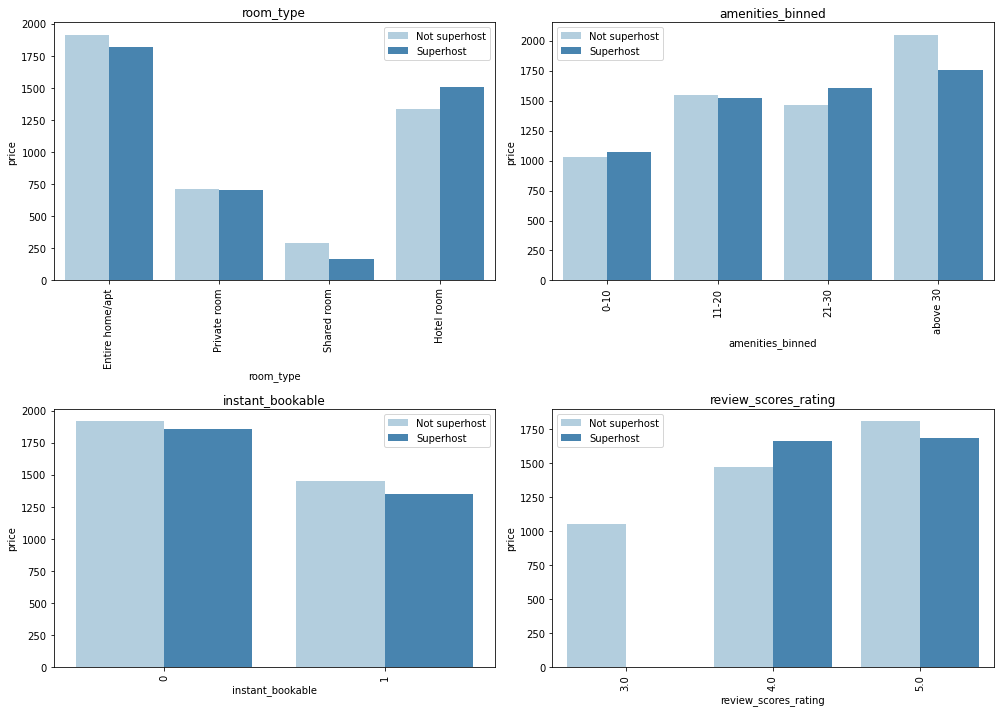

In [156]:

cols = ['room_type', 'amenities_binned', 'instant_bookable', 'review_scores_rating']

a = 2
b = 2
c = 1  

fig = plt.figure(figsize=(14,10))

for i in cols:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    plt.xlabel(i)
    sns.barplot(x = i,y='price', data=new_df1,hue='host_is_superhost', ci=None, palette='Blues')
    plt.xticks(rotation = 90)
    plt.legend(labels=['Not superhost','Superhost'], loc='best')
    c = c + 1

plt.tight_layout()
plt.show()



* Except for hotel rooms, superhosts tend to charge cheaper on average. This could be attributed to the fact that superhosts enjoy more bookings, so even with lower prices, they end up making more money.
* Airbnbs that are not instantly bookable fetch higher prices. The instant booking is mostly used by new hosts in the business who want to increase the response time and rate and attract more reviews. So, in the same way, they may reduce prices to attract new clients.
* The higher the number of amenities, the higher the price. Even with same number of amenities, the average price is higher in superhost airbnbs. Standard hosts have to have way more high number of amenities to charge more than superhosts.
* Higher ratings definitely fetch higher prices. The pricing for ratings of 4 and 5 is almost same for superhosts. In this case, a user would definitely go for the 5 star. It would be advisable to aim for the 5 star

### Perks of being a superhost

* Priority support from airbnb
* Superhost badge leads to more visibility and more bookings, more bookings equals more income

## 5.3 Reviews sentiment Analysis

We will do a sentiment analysis of reviews to see which words are commonly used in the positive reviews

In [157]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,30332317,597314314,2020-01-25,7812767,Alan,Lovely rustic accommodation in a picturesque r...
1,30332317,532436007654450454,2022-01-04,367340518,Courtney,The hosts are friendly and takes good care of ...
2,9126484,63063726,2016-02-20,50272994,Carla,6 St Georges Building was lovely in every way....
3,9126484,67195563,2016-03-27,59937103,Gau,"Our host Bruce was great. Responsive, helpful ..."
4,9126484,68077701,2016-04-02,19226497,Imke,Bruce was incredibly welcoming and very flexib...


In [158]:
reviews_copy = reviews_df.copy()

In [159]:
# make a list for all the comments to be used for sentiment analysis
all_comments = reviews_copy.comments.tolist() 

### 5.3.1 Doing sentiment analysis

In [160]:

sentiment = ""

def sentiment_scores(review_comment):
    
    # Create a SentimentIntensityAnalyzer object.
    sen_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer object gives a sentiment dictionary which contains
    #pos, neg, neu, and compound scores.
        
    sentiment_dict = sen_obj.polarity_scores(review_comment)
     
        # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
     
        sentiment = 'Positive'
              
    elif sentiment_dict['compound'] <= - 0.05 :
       
        sentiment = 'Negative'
      
    else :
       
        sentiment = 'Neutral'
          
    return sentiment

#The compound score is a metric that calculates the sum of all the lexicon ratings which have
#been normalized between -1(most extreme negative) and +1 (most extreme positive).
#positive sentiment : (compound score >= 0.05) 
#neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 
#negative sentiment : (compound score <= -0.05)
#link :https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
 

In [161]:
#get the sentiments for every comment
#the_sentiments = [sentiment_scores(comment) for comment in all_comments]

In [162]:
#with open('/content/drive/Shareddrives/CapStone/Data/sentiments_list.pkl','wb') as f:
  #pickle.dump(the_sentiments, f)

In [163]:
with open('/content/drive/Shareddrives/CapStone/Data/sentiments_list.pkl','rb') as f:
  sentiments_list = pickle.load(f)

 * we will then add these setiments to the reviews dataframe as an extra column called sentiment  

In [164]:
reviews_copy['sentiment'] = sentiments_list

* Now we know which comments are positive, negative or neutral

### 5.3.2 Creating a bag of words

* We need the words that are most common in positive reviews and also negative reviews, so we subdivide our dataframe into those two

In [165]:
reviews_positive = reviews_copy[reviews_copy['sentiment']== 'Positive']
reviews_negative = reviews_copy[reviews_copy['sentiment']== 'Negative']

In [166]:
#negative and positive comments
positive_comments = reviews_positive.comments.tolist()
negative_comments = reviews_negative.comments.tolist()

In [169]:
# creating bag of words
useful_tags = ['ADJ', 'ADV','VERB','X'] # tags from  https://universaldependencies.org/u/pos/
 # list to hold the words
all_words = []
stop_words=  stopwords.words('english')

def bag_of_words(the_comments):
       
    #lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    for comment in the_comments:
        
        try:
             # Removes special characters
            text = re.sub('[^a-zA-Z]', ' ', comment)
            text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
            text = re.sub("(\\d|\\W)+"," ",text)
            text = text.lower()

            comment_tokenized = nltk.word_tokenize(text)  # Split the line of comment into a list of words. 
            
            for i in range(0, len(comment_tokenized)):
                comment_tokenized[i] = lemmatizer.lemmatize(comment_tokenized[i], pos="v")#lemmatize every word in the text
            
            #remove stopwords
            comment_no_stopwords = [word for word in comment_tokenized if not word in stop_words]

            comment_tagged = nltk.pos_tag(comment_no_stopwords, tagset='universal') 
    #pos tagging is  categorizing words in a text (corpus) in correspondence with a particular part of speech, 
    #depending on the definition of the word and its context. returns a tuple with the word and the part of speech
            
            for word in comment_tagged:    
                if word[1] in useful_tags:# word[1] is the part of speech
                    all_words.append(word[0]) # word[0] is the word
        
                 
        except TypeError: 
            print(comment)
            continue

In [170]:
# bag of words for positive comments...this code takes long to run
#bag_of_words(positive_comments) 

#positive_list = all_words

In [171]:
#with open('/content/drive/Shareddrives/CapStone/Data/positives.pkl','wb') as f:
  #pickle.dump(positive_list, f)

In [172]:
with open('/content/drive/Shareddrives/CapStone/Data/positives.pkl','rb') as f:
  positive_list = pickle.load(f)

In [173]:
positive_list[:10]

['lovely',
 'rustic',
 'rural',
 'great',
 'able',
 'spend',
 'explore',
 'delight',
 'fowl',
 'silly']

In [174]:
# bag of words for negative comments.This code also takes long to run
#all_words.clear()
#bag_of_words(negative_comments)
#negative_words = all_words

In [175]:
#with open('/content/drive/Shareddrives/CapStone/Data/negatives.pkl','wb') as f:
  #pickle.dump(negative_words, f)

In [176]:
with open('/content/drive/Shareddrives/CapStone/Data/negatives.pkl','rb') as f:
  negative_words = pickle.load(f)

In [177]:
negative_words[:10]

['terrible',
 'terrible',
 'host',
 'even',
 'give',
 'almost',
 'leave',
 'das',
 'sicher',
 'gefunden']

In [178]:
# word frequency
def freq_distribution(list_words, n= None):
  fdist = nltk.FreqDist(list_words)
  most_common = fdist.most_common()
  return most_common[:n]

In [179]:
# top 10 frequency distribution for positive comments
freq_distribution(positive_list, 10)

[('great', 166588),
 ('stay', 72165),
 ('recommend', 66330),
 ('clean', 61982),
 ('would', 57740),
 ('beautiful', 56363),
 ('lovely', 56330),
 ('well', 50173),
 ('nice', 49155),
 ('definitely', 48802)]

In [180]:
# frequency distribution for negative comments- i don't understand these words. I think some translation is needed
freq_distribution(negative_words, 10)

[('und', 7034),
 ('die', 4772),
 ('uns', 4284),
 ('auch', 3023),
 ('ist', 2953),
 ('unterkunft', 2863),
 ('das', 2725),
 ('br', 2556),
 ('sehr', 2382),
 ('den', 2367)]

In [181]:
# creating a dataframe for the positive frequency
most_common_pos = freq_distribution(positive_list, 20)
word, freq = zip(*most_common_pos)

In [182]:
words_df = pd.DataFrame({'Word': word,'Frequency':freq})
                                        
words_df.head()

,Word,Frequency
0,great,166588
1,stay,72165
2,recommend,66330
3,clean,61982
4,would,57740


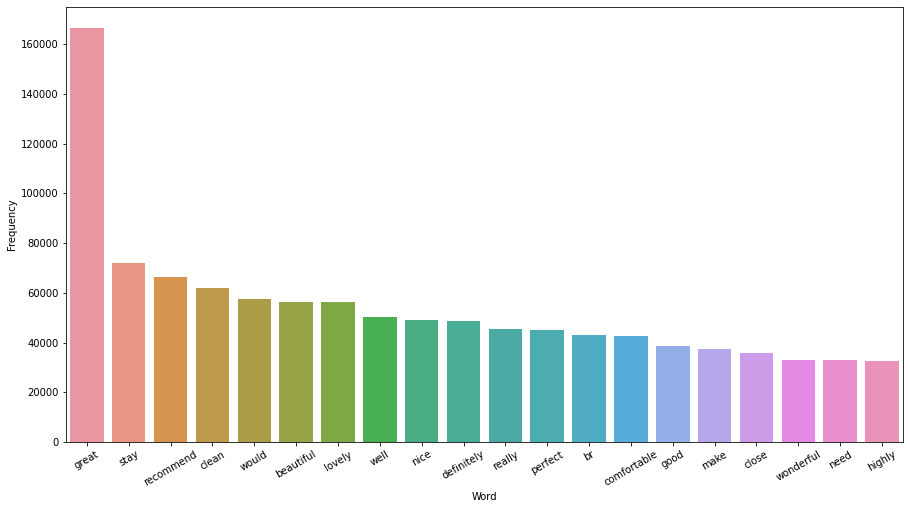

In [183]:
# plotting top n frequencies
def get_top_n_words(words_frame, n=None):
    
    frame = words_frame.head(n) # top n words
    
    return frame

top_words = get_top_n_words(words_df, n=20)

plt.rcParams['figure.figsize']=(15,8)
g = sns.barplot(x = 'Word', y = 'Frequency', data = top_words)

g.set_xticklabels(g.get_xticklabels(), rotation=30);

# Preprocessing

In [184]:
listings_df.drop(columns= ['index'], inplace= True)

In [185]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17474 entries, 0 to 17473
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              17474 non-null  int64   
 1   listing_url                     17474 non-null  object  
 2   host_url                        17474 non-null  object  
 3   name                            17474 non-null  object  
 4   description                     17474 non-null  object  
 5   neighborhood_overview           17474 non-null  object  
 6   neighbourhood_cleansed          17474 non-null  object  
 7   host_response_time              17474 non-null  object  
 8   host_response_rate              17474 non-null  float64 
 9   host_acceptance_rate            17474 non-null  float64 
 10  host_is_superhost               17474 non-null  int64   
 11  property_type                   17474 non-null  object  
 12  room_type         

In [186]:
amens= listings_df['amenities'].apply(lambda x: ','.join(x))
amens[:10]

0    Hot water,Cooking basics,Iron,Free parking on ...
1    Hot water,Cooking basics,Iron,Drying rack for ...
2    TV,Long term stays allowed,Cooking basics,Kitc...
3    TV,Gym,Long term stays allowed,Heating,Shampoo...
4    TV,Long term stays allowed,Heating,Indoor fire...
5    Hot water,Cleaning products,Cooking basics,Ind...
6    Long term stays allowed,Dryer,Indoor fireplace...
7    TV,Hot water,Shared pool,Shampoo,Iron,Hangers,...
8    Hot water,Indoor fireplace,Shared pool,Iron,BB...
9    TV,Long term stays allowed,Heating,Shampoo,Han...
Name: amenities, dtype: object

In [187]:
listings_df_copy = listings_df.copy()

In [188]:
type(listings_df_copy['room_type'][1])

str

In [189]:
listings_df_copy['amenities'] = listings_df_copy['amenities'].apply(lambda x: ','.join(x))

In [190]:
listings_df_copy['contents'] = (listings_df_copy['name'] + ' ' + listings_df_copy['description'] +
                                ' ' + listings_df_copy['neighborhood_overview'] + 
                                ' ' + listings_df_copy['property_type'] +
                                ' ' + listings_df_copy['room_type'] +
                                ' ' + listings_df_copy['amenities'] +
                                ' ' + listings_df_copy['cities'])

In [191]:
symbols = ['<br />', '<b>', '</b>']
word= listings_df_copy['contents'][1]
word= word.replace('</b>', '')
word= word.replace('<b>', '')
word= word.replace('<br />', '')
word

"Jubilee Square Apartment Comfortably furnished 1st floor 2 bedroom apartment in the heart of the historical village of Simon's Town, on the beautiful False Bay coast. The apartment overlooks Jubilee Square with a partial view of Simon's Bay and the boat marina through the trees.The spaceMain bedroom with King size bed and has separate access to the bathroom. Second bedroom with 2 x Single beds. Full bathroom with toilet, bath & shower over the bath. Kitchen is fully equipped for cooking with all the utensils you might need, including a dish washer. The balcony overlooks the main street and Jubilee Square. The building has its own coin operated laundry facility. There is Wi-Fi and also a smart TV with Netflix, however there is no DSTV. Please note this is strictly a non-smoking apartment.Guest accessWhole apartment.Other things to noteNon-smoking apartment. The apartment is situated on the main street directly opposite Jubilee Square. (center of town) Simon's Town is a historical naval

In [192]:
pd.set_option('display.max_columns', None)

In [193]:
# Creating a function that will preprocess and standardize the text for NLP 
def preprocess(text):
    ''' This function takes text to preprocess and standardize it for the purpose of NLP '''
 
    # Lowercase the text 
    text = text.str.lower()
    text= text.apply(lambda x: x.replace('</b>', ''))
    text= text.apply(lambda x: x.replace('<b>', ''))
    text= text.apply(lambda x: x.replace('<br />', ''))
    
    # Remove punctuations using string module with regular expression
    text = text.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

    # Split string by whitespace and remove extra whitespaces 
    text = text.apply(lambda x: x.split())

    # Remove stopwords 
    stopwords = nltk.corpus.stopwords.words('english')
    text = text.apply(lambda x: [word for word in x if word not in stopwords])

    # Lemmatize text to group together words with the same root or lemma
    from nltk.stem.wordnet import WordNetLemmatizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    text = text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    text = text.apply(lambda x: ' '.join(x))

    return text

In [194]:
listings_df_copy['contents'] = preprocess(listings_df_copy['contents'])
listings_df_copy['contents'][1]

'jubilee square apartment comfortably furnished 1st floor 2 bedroom apartment heart historical village simon town beautiful false bay coast apartment overlook jubilee square partial view simon bay boat marina tree spacemain bedroom king size bed separate access bathroom second bedroom 2 x single bed full bathroom toilet bath shower bath kitchen fully equipped cooking utensil might need including dish washer balcony overlook main street jubilee square building coin operated laundry facility wi fi also smart tv netflix however dstv please note strictly non smoking apartment guest accesswhole apartment thing notenon smoking apartment apartment situated main street directly opposite jubilee square center town simon town historical naval village restaurant coffee shop lot quirky shop selling different thing clothing nautical artifact thing need within walking distance take drive kalk bay find excellent restaurant fishing boat return around midday take stroll harbor pick fresh fish dinner ev

Count vectorizer

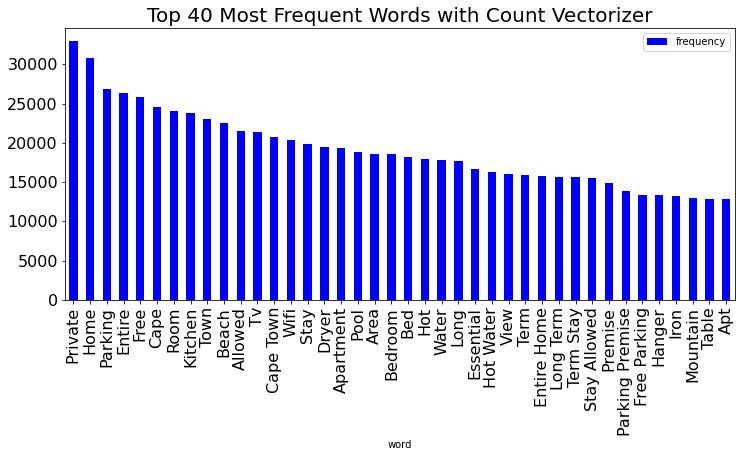

In [195]:
# Convert the content column to a matrix of word counts
# Most frequent words with Count Vectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(1,2))
cv_matrix = cv.fit_transform(listings_df_copy['contents'])
cv_total = cv_matrix.sum(axis=0)

cv_freq = [(word.title(), cv_total[0, i]) for word, i in cv.vocabulary_.items()]
cv_freq = sorted(cv_freq, key = lambda x: x[1], reverse = True)
cv_frequency = pd.DataFrame(cv_freq, columns=['word', 'frequency'])

# Plotting Top 40 Most Frequent Words with CV 
cv_frequency.head(40).plot(x='word', y='frequency', kind='bar', figsize=(12, 5), color = 'blue')
plt.title('Top 40 Most Frequent Words with Count Vectorizer', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

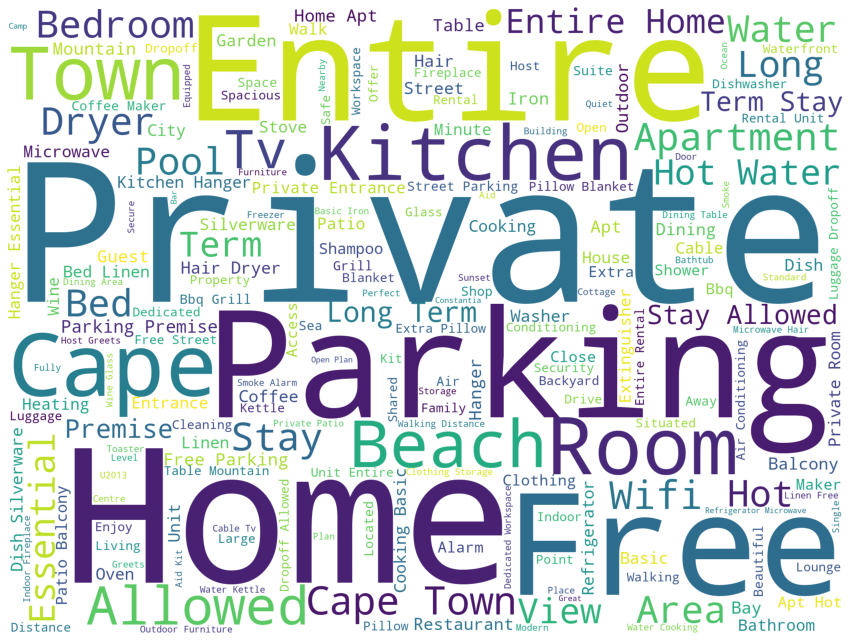

In [196]:
# Wordcloud of the words with Count Vectorizer 

wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(cv_freq))
plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis('off');

In [197]:
query = cv.transform(['I want an apartment in cape town with free parking'])
print(cosine_similarity(query, cv_matrix))

[[0.07051507 0.18662779 0.09944903 ... 0.19247794 0.12826707 0.08253478]]


In [198]:
similarity = cosine_similarity(query, cv_matrix)
np.argsort(similarity[0])[-5:]

array([11838, 10728, 16982, 10296, 13030])

In [199]:
listings_df.loc[13030]

id                                                                         52071738
listing_url                                   https://www.airbnb.com/rooms/52071738
host_url                                 https://www.airbnb.com/users/show/22496581
name                               Studio Apt 5mins to Biscuit Mill + Cape Town CBD
description                       Clean, stylish, safe & comfortable apartment o...
neighborhood_overview             Woodstock is the grungy, urban creative heart ...
neighbourhood_cleansed                                                     Ward 115
host_response_time                                               within a few hours
host_response_rate                                                            100.0
host_acceptance_rate                                                          100.0
host_is_superhost                                                                 1
property_type                                                          Entir

In [200]:
def recommend_five():
    ''' This function asks the user a question and then takes in the answer to finds the top 5 similar listings '''
    
    question = input('What are some features you are interested in? ')
    # count vectorize the question
    inquiry = cv.transform([question])

    # Calculate cosine similarity of inquiry with the cv_matrix
    similarity = cosine_similarity(inquiry, cv_matrix)
    
    # Obtain the index then sort, picking top 5
    nums = np.argsort(similarity[0])[-5:]

    #return the top 5
    return listings_df['name'].loc[nums]

In [201]:
recommend_five()

What are some features you are interested in? home


6108              Gorgeous family home in Kenilworth Upper
4625                            Where Beach meets Country.
13650      Gay Owned Muizenberg Home - 100m from the beach
13206    Cheerful 4 bedroom family home with ample parking
11639    A HOME AWAYFROM HOME! PERFECT FAMILY HOLIDAY H...
Name: name, dtype: object

## TF-IDF Vectorizer
TF-IDF is a method that assigns a numerical weightage of words which reflects how important the particular word is to a document in corpus. N-grams are continuous sequence of words or symbols or tokens in a document. The text will be vectorized the text data with TF-IDF using Unigrams, Bigrams and Trigrams and evaluate the most frequent words with each ngram.

## TF-IDF Unigram

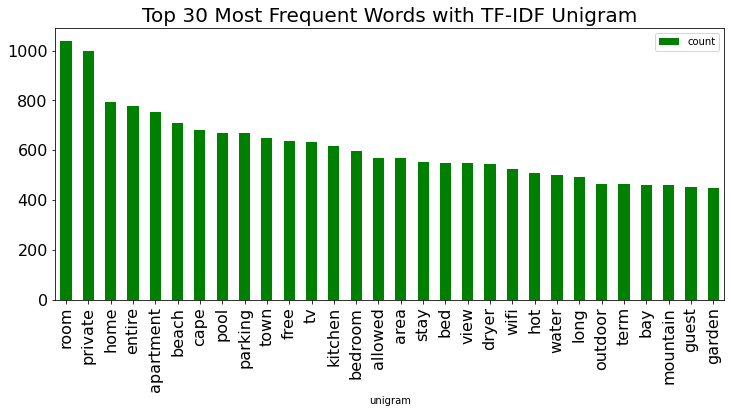

In [202]:
# Converting text descriptions into vectors using TF-IDF using Unigrams
tf = TfidfVectorizer(ngram_range=(1, 1), lowercase = False)
tf_matrix = tf.fit_transform(listings_df_copy['contents'])
tf_total = tf_matrix.sum(axis=0) 
# Finding the word frequency
tf_freq = [(word, tf_total[0, idx]) for word, idx in tf.vocabulary_.items()]
tf_freq = sorted(tf_freq, key = lambda x: x[1], reverse=True)
# Converting into dataframe 
unigram = pd.DataFrame(tf_freq, columns = ['unigram', 'count'])

# Plotting the bigram distribution of top 30 words 
unigram.head(30).plot(x='unigram', y='count', kind='bar', figsize=(12, 5), color = 'green')
plt.title('Top 30 Most Frequent Words with TF-IDF Unigram', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

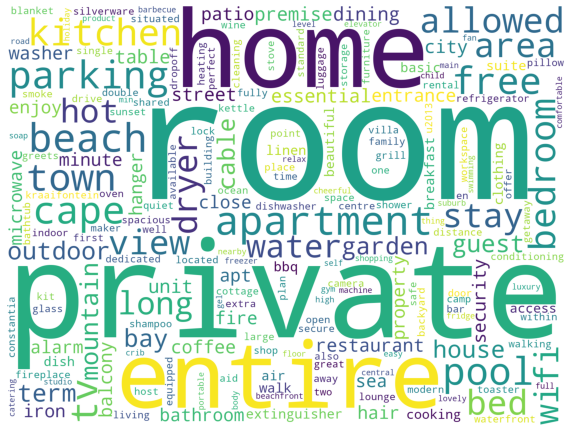

In [203]:
# Wordcloud of the words with TF-IDF Vectorizer with Unigram
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(tf_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off');

## TF-IDF Bigram

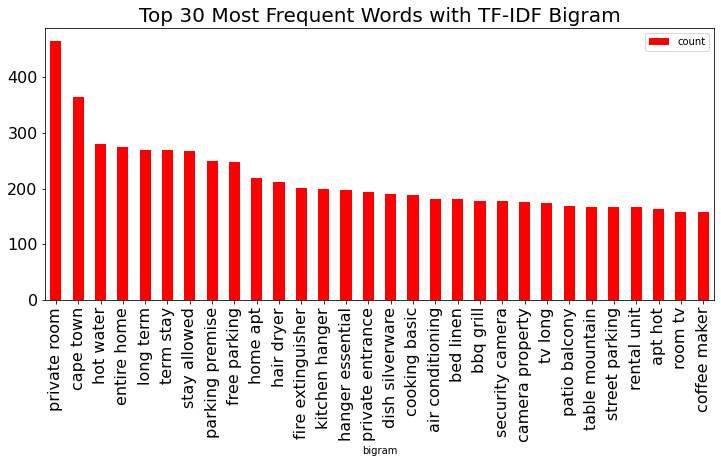

In [204]:
# Converting text descriptions into vectors using TF-IDF using Bigram
tf2 = TfidfVectorizer(ngram_range=(2, 2), lowercase = False)
tf2_matrix = tf2.fit_transform(listings_df_copy['contents'])
tf2_total = tf2_matrix.sum(axis=0) 
# Finding the word frequency
tf2_freq = [(word, tf2_total[0, idx]) for word, idx in tf2.vocabulary_.items()]
tf2_freq = sorted(tf2_freq, key = lambda x: x[1], reverse=True)
# Converting into dataframe 
bigram = pd.DataFrame(tf2_freq, columns = ['bigram', 'count'])

# Plotting the bigram distribution of top 30 words 
bigram.head(30).plot(x='bigram', y='count', kind='bar', figsize=(12, 5), color = 'red')
plt.title('Top 30 Most Frequent Words with TF-IDF Bigram', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

In [205]:
# # Word cloud with TF-IDF Bigram in House Shape
# from PIL import Image
# from wordcloud import ImageColorGenerator
# house_mask = np.array(Image.open("Images/house.png"))

# wordcloud = WordCloud(width=1000, height=1000, background_color="black", mask=house_mask, colormap='Reds_r', 
# stopwords=["size bed", "queen size"], random_state=1, contour_width=0, contour_color=None).generate_from_frequencies(dict(tf2_freq))

# plt.figure(figsize=[12, 12])
# plt.imshow(wordcloud, interpolation='bilinear')
# #plt.tight_layout(pad=0)
# plt.axis('off');

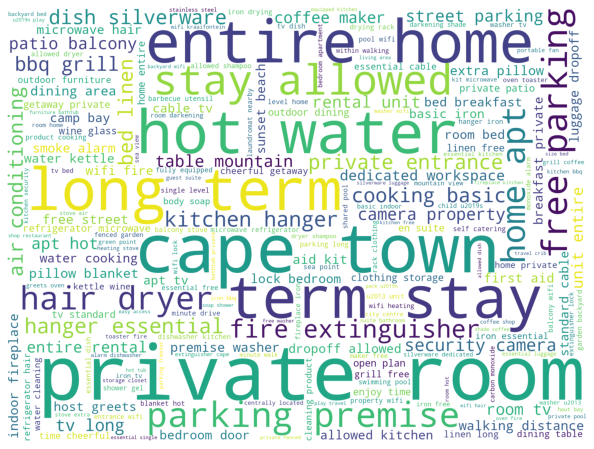

In [206]:
# Wordcloud of the words with TF-IDF Vectorizer with Bigram
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(tf2_freq))
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud)
plt.axis('off');